In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
import random
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization

In [441]:
def evaluate_model(y_pred_train, y_pred_test, y_train, y_test):
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    
    print("MAE train: ", mae_train)
    print("MAE test: ", mae_test)
    print("RMSE train: ", rmse_train)
    print("RMSE test: ", rmse_test)
    print("R2 train: ", r2_train)
    print("R2 test: ", r2_test)

In [442]:
def plot_predictions(y_test_real, y_pred_test_real):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_real, label="Real", color="blue")
    plt.plot(y_pred_test_real, label="Predicho", color="orange")
    plt.title("Predicciones vs. Valores Reales")
    plt.legend()
    plt.show()

In [443]:
def create_sequences(X, y, n_steps):
    Xs, ys = [], []
    for i in range(len(X) - n_steps):
        Xs.append(X[i:i + n_steps])
        ys.append(y[i + n_steps])
    return np.array(Xs), np.array(ys)

In [444]:
df = pd.read_csv('../../data/pre_train/gspc.csv', index_col='date')
df.index = pd.to_datetime(df.index)
df = df.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')

C:\Users\santi\AppData\Local\Temp\ipykernel_17988\2841548648.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


In [445]:
X = df.drop(columns=['close', 'log_close'])
y = df['log_close']

In [446]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.to_numpy().reshape(-1, 1))

In [447]:
time_steps = 50
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)

train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

In [ ]:
n_features = X_train.shape[2] 

SEED = 1
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()

model = Sequential([
    LSTM(128, return_sequences=False, input_shape=(time_steps, n_features)),
    Dropout(0.20),
    Dense(32, activation='relu', kernel_regularizer=l2(0.0005)),
    Dense(16, activation='relu'),
    Dense(1)
])

c:\Users\santi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [449]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

In [450]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stop])


Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - loss: 0.2393 - mae: 0.3923 - val_loss: 0.0809 - val_mae: 0.2125
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0445 - mae: 0.0882 - val_loss: 0.0437 - val_mae: 0.0987
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0366 - mae: 0.0511 - val_loss: 0.0363 - val_mae: 0.0631
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0341 - mae: 0.0444 - val_loss: 0.0354 - val_mae: 0.0689
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0322 - mae: 0.0411 - val_loss: 0.0346 - val_mae: 0.0746
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0301 - mae: 0.0357 - val_loss: 0.0303 - val_mae: 0.0540
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0290 - mae: 0.0394 - val_loss: 0.0289 - val_mae: 0.0543
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0275 - mae: 0.0384 - val_loss: 0.0280 - val_mae: 0.0582
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - lo

In [451]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test) 

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [452]:
y_pred_train = y_pred_train.reshape(-1, 1)
y_pred_test = y_pred_test.reshape(-1, 1)

In [453]:
y_train_real = scaler_y.inverse_transform(y_train.reshape(-1, 1))
y_test_real = scaler_y.inverse_transform(y_test.reshape(-1, 1))
y_pred_train_real = scaler_y.inverse_transform(y_pred_train)
y_pred_test_real = scaler_y.inverse_transform(y_pred_test)

In [455]:
evaluate_model(y_pred_train_real, y_pred_test_real, y_train_real, y_test_real)

MAE train:  0.016580156609258847
MAE test:  0.015014865116996413
RMSE train:  0.022471370195784414
RMSE test:  0.018828427800435477
R2 train:  0.9731629261823826
R2 test:  0.9123426172496187


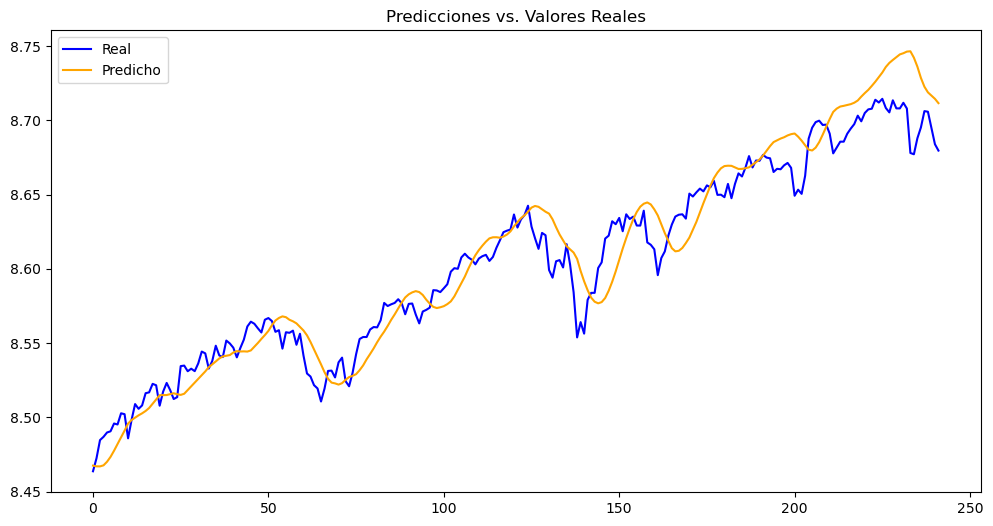

In [456]:
plot_predictions(y_test_real, y_pred_test_real)

In [461]:
def build_model(hp):
    model = Sequential([
        LSTM(hp.Int('units', min_value=64, max_value=128, step=64),
             return_sequences=False, 
             input_shape=(X_train.shape[1], X_train.shape[2]),
             kernel_regularizer=l2(hp.Choice('l2', [0.0001, 0.0005, 0.001]))),
        Dropout(hp.Float('dropout', min_value=0.1, max_value=0.3, step=0.05)),
        Dense(32, activation='relu', kernel_regularizer=l2(hp.Choice('l2', [0.0001, 0.0005, 0.001]))),
        Dense(16, activation='relu'),
        Dense(1)
    ])

    optimizer = Adam(learning_rate=hp.Choice('lr', [0.0001, 0.0005, 0.001, 0.002]))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

In [462]:
tuner = kt.Hyperband(build_model,
                     objective='val_loss',
                     max_epochs=50,
                     factor=3,
                     directory='my_dir',
                     project_name='sp500_lstm')

c:\Users\santi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [463]:
tuner.search(X_train, y_train,
             epochs=50,
             batch_size=64,
             validation_data=(X_test, y_test),
             callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

Trial 90 Complete [00h 00m 15s]
val_loss: 0.0066114766523242

Best val_loss So Far: 0.000745618250221014
Total elapsed time: 00h 22m 07s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Mejor configuración encontrada:\n"
      f"Unidades LSTM: {best_hps.get('units')}\n"
      f"Dropout: {best_hps.get('dropout')}\n"
      f"L2: {best_hps.get('l2')}\n"
      f"Learning Rate: {best_hps.get('lr')}")

Mejor configuración encontrada:
Unidades LSTM: 128
Dropout: 0.1
L2: 0.0001
Learning Rate: 0.002


In [466]:
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(X_train, y_train, epochs=100, batch_size=64,
               validation_data=(X_test, y_test),
               callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 201ms/step - loss: 0.0997 - mae: 0.2356 - val_loss: 0.0072 - val_mae: 0.0145
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0102 - mae: 0.0480 - val_loss: 0.0108 - val_mae: 0.0620
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0088 - mae: 0.0372 - val_loss: 0.0080 - val_mae: 0.0368
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0083 - mae: 0.0344 - val_loss: 0.0076 - val_mae: 0.0340
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0078 - mae: 0.0322 - val_loss: 0.0071 - val_mae: 0.0296
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0075 - mae: 0.0303 - val_loss: 0.0065 - val_mae: 0.0238
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0073 - mae: 0.0302 - val_loss: 0.0059 - val_mae: 0.0171
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0067 - mae: 0.0268 - val_loss: 0.0066 - val_mae: 0.0329
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - l

In [467]:
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test) 

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [468]:
y_pred_train = y_pred_train.reshape(-1, 1)
y_pred_test = y_pred_test.reshape(-1, 1)

In [469]:
y_train_real = scaler_y.inverse_transform(y_train.reshape(-1, 1))
y_test_real = scaler_y.inverse_transform(y_test.reshape(-1, 1))
y_pred_train_real = scaler_y.inverse_transform(y_pred_train)
y_pred_test_real = scaler_y.inverse_transform(y_pred_test)

In [470]:
evaluate_model(y_pred_train_real, y_pred_test_real, y_train_real, y_test_real)

MAE train:  0.012875221645006244
MAE test:  0.009809977919615529
RMSE train:  0.017414021298707012
RMSE test:  0.012931699994598478
R2 train:  0.9838833715258686
R2 test:  0.9586503701429359


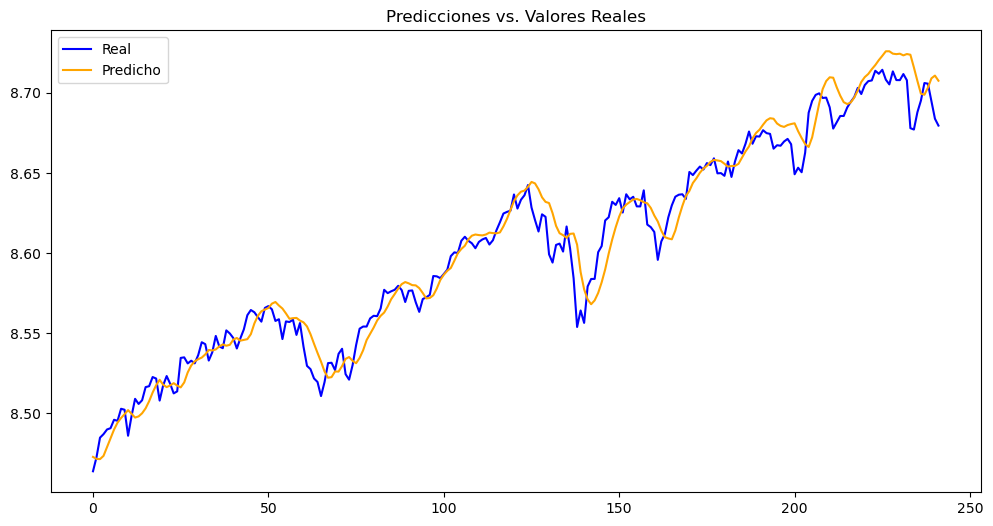

In [471]:
plot_predictions(y_test_real, y_pred_test_real)

In [523]:
time_steps = 50
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)

In [524]:
train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

In [525]:
best_model.fit(X_train, y_train, epochs=100, batch_size=64,
               validation_data=(X_test, y_test),
               callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 5.8662e-04 - mae: 0.0158 - val_loss: 3.5058e-04 - val_mae: 0.0115
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 5.2024e-04 - mae: 0.0145 - val_loss: 3.7356e-04 - val_mae: 0.0112
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 4.8166e-04 - mae: 0.0139 - val_loss: 3.4431e-04 - val_mae: 0.0110
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 4.6959e-04 - mae: 0.0136 - val_loss: 3.5115e-04 - val_mae: 0.0109
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 4.8226e-04 - mae: 0.0139 - val_loss: 3.3977e-04 - val_mae: 0.0108
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 4.8865e-04 - mae: 0.0143 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 5.5015e-04 - mae: 0.0157 - val_loss: 3.3999e-04 - val_mae: 0.0104
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 5.1070e-04 - mae: 0.0146 - val_loss: 4.0062e-04 - val_mae: 0.0

In [526]:
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [527]:
y_train_real = scaler_y.inverse_transform(y_train.reshape(-1, 1))
y_test_real = scaler_y.inverse_transform(y_test.reshape(-1, 1))
y_pred_train_real = scaler_y.inverse_transform(y_pred_train)
y_pred_test_real = scaler_y.inverse_transform(y_pred_test)

In [528]:
evaluate_model(y_pred_train_real, y_pred_test_real, y_train_real, y_test_real)

MAE train:  0.012807668035203348
MAE test:  0.009558290217265729
RMSE train:  0.017162668455550915
RMSE test:  0.012107069384306005
R2 train:  0.9843452665323783
R2 test:  0.9637558059107205


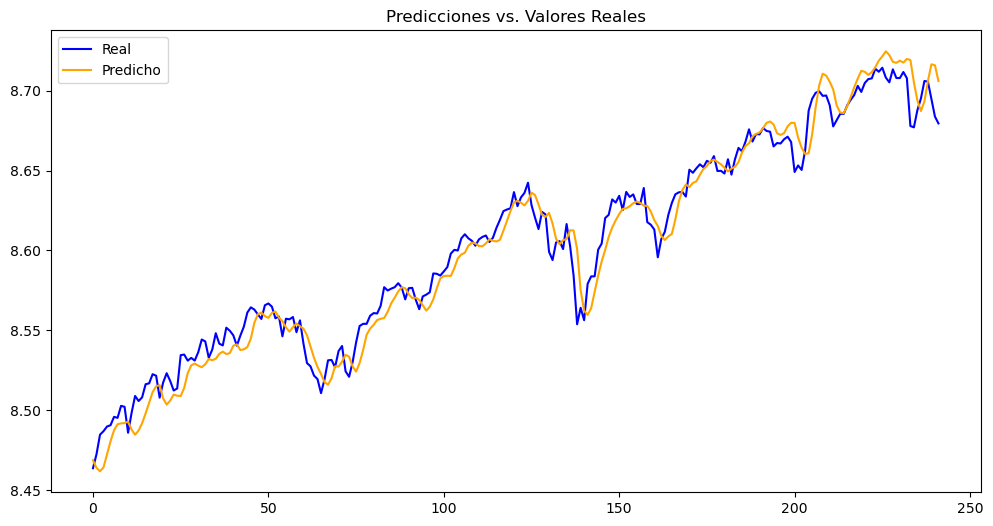

In [529]:
plot_predictions(y_test_real, y_pred_test_real)

In [530]:
best_model.save('best_model.h5')